## 3 特征工程
- 数据预处理
  - 缺失值的填充
  - 时间格式处理
  - 对象类型特征转换到数值
- 异常值处理
  - 基于3$\sigma$原则
  - 基于箱型图
- 数据分箱
  - 固定宽度分箱
  - 分位数分箱
    - 离散数值型数据分箱
    - 连续数值型数据分箱
  - 卡方分箱（选做作业）
- 特征交互
  - 特征和特征之间组合
  - 特征和特征之间衍生
  - 其他特征衍生的尝试（选做作业）
- 特征编码
  - one-hot编码
  - label-encode编码
- 特征选择
    - 1 Filter
    - 2 Wrapper （RFE）
    - 3 Embedded

### 3.1 导入包并读取数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
warnings.filterwarnings('ignore')

C:\Users\Poppy\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


In [2]:
# 读取数据
train = pd.read_csv('./train.csv')
test_a = pd.read_csv('./testA.csv')

### 3.2特征预处理

- 数据EDA部分我们已经对数据的整体和某些特征分布有了了解，数据预处理部分一般我们要处理一些EDA阶段分析出来的问题
- 本部分完成了数据缺失值的填充，时间格式特征的转化处理，某些对象类别特征的处理。

首先我们查找出数据中的对象特征和数值特征

In [3]:
# 数据类型数据
numerical_fea = list(train.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(train.columns)))
label = 'isDefault'
numerical_fea.remove(label)

pandas.DataFrame.select_dtypes 根据数据类型选择特征


    To select all numeric types, use np.number or 'number'

    To select strings you must use the object dtype, but note that this will return all object dtype columns

    See the numpy dtype hierarchy

    To select datetimes, use np.datetime64, 'datetime' or 'datetime64'

    To select timedeltas, use np.timedelta64, 'timedelta' or 'timedelta64'

    To select Pandas categorical dtypes, use 'category'

    To select Pandas datetimetz dtypes, use 'datetimetz' (new in 0.20.0) or 'datetime64[ns, tz]'


EDA要首先对数据进行清洗，主要是对脏数据的处理。包括缺失值异常值的处理。

### 缺失值的填充

In [4]:
# 把所有缺失值替换为指定的值0
# train = train.fillna(0)
# 用缺失值上面的值替换缺失值
# train = train.fillna(axis=0,method='ffill')
# 纵向用缺失值下面的值替换缺失值,且设置最多只填充两个连续的缺失值
# train = train.fillna(axis=0,method='bfill',limit=2)

#查看缺失值情况
train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n2.1                

In [5]:
#按照平均数填充数值型特征 *.median()
train[numerical_fea] = train[numerical_fea].fillna(train[numerical_fea].median())
test_a[numerical_fea] = test_a[numerical_fea].fillna(train[numerical_fea].median())
#按照众数填充类别型特征 *.mode()
# train[category_fea] = train[category_fea].fillna(data_train[category_fea].mode())
# test_a[category_fea] = test_a[category_fea].fillna(data_train[category_fea].mode())

In [6]:
# 查看分类类型的数据特征
category_fea

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [7]:
train.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n2.1                

可以发现在分类类型的数据特征中，只有employmentLength有缺失值，并且缺失值很多。对象型类别特征需要进行预处理，其中['issueDate']为时间格式特征。

### 时间格式数据处理

In [8]:
#转化成时间格式
for data in [train, test_a]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format='%Y-%m-%d')
    startdate = datetime.datetime.strptime('2007-06-01', '%Y-%m-%d')
    #构造时间特征
    data['issueDateDT'] = data['issueDate'].apply(lambda x: x-startdate).dt.days
    
train['employmentLength'].value_counts(dropna=False).sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
NaN           46799
Name: employmentLength, dtype: int64

employmrntLength的缺失值比较多，NaN值有46799，一定要对改数据特征进行处理，或者简单舍弃该特征。

Python time strptime() 函数根据指定的格式把一个时间字符串解析为时间元组
strptime()方法语法：
`time.strptime(string[, format])`

string -- 时间字符串。
format -- 格式化字符串

返回struct_time对象

- %y 两位数的年份表示（00-99）
- %Y 四位数的年份表示（000-9999）
- %m 月份（01-12）
- %d 月内中的一天（0-31）
- %H 24小时制小时数（0-23）
- %I 12小时制小时数（01-12）
- %M 分钟数（00-59）
- %S 秒（00-59）

#### 对象类型数据特征转换到数值

- 对employmentLength进行处理

In [9]:
# 把employmentLength数据进行数值化，直接将* year 转换成year
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
for data in [train, test_a]:
    data['employmentLength'].replace(to_replace='10+ years', value='10 years', inplace=True)
    data['employmentLength'].replace('< 1 year', '0 years', inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [10]:
data['employmentLength'].value_counts(dropna=False).sort_index()

0.0     15989
1.0     13182
2.0     18207
3.0     16011
4.0     11833
5.0     12543
6.0      9328
7.0      8823
8.0      8976
9.0      7594
10.0    65772
NaN     11742
Name: employmentLength, dtype: int64

- 对earliesCreditLine进行预处理

In [11]:
train['earliesCreditLine'].sample(10)

637031    Sep-1997
28458     Oct-2012
20749     Mar-1990
212558    Apr-2003
83753     Aug-2001
636072    Nov-2002
784436    May-2002
60273     May-2004
772323    May-1999
245628    Jan-1999
Name: earliesCreditLine, dtype: object

In [12]:
# 使用earliesCreditLine的最后四个bit即年份代表这个数据特征
for data in [train, test_a]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s: int(s[-4:]))

In [13]:
data['earliesCreditLine'].sample(5)

17215     2002
94877     2001
157409    1995
85507     1996
57148     1994
Name: earliesCreditLine, dtype: int64

#### 类别特征处理

In [14]:
cate_features = ['grade', 'subGrade', 'employmentTitle', 'homeOwnership', 'verificationStatus', 'purpose', 'postCode', 'regionCode', \
                 'applicationType', 'initialListStatus', 'title', 'policyCode']
for f in cate_features:
    print(f, '特征数：', data[f].nunique())

grade 特征数： 7
subGrade 特征数： 35
employmentTitle 特征数： 79282
homeOwnership 特征数： 6
verificationStatus 特征数： 3
purpose 特征数： 14
postCode 特征数： 889
regionCode 特征数： 51
applicationType 特征数： 2
initialListStatus 特征数： 2
title 特征数： 12058
policyCode 特征数： 1


像等级这种类别特征，没有优先级的可以labelencode或者自映射

In [15]:
for data in [train, test_a]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})
# 类型数在2之上，不是高维稀疏的,且是分类特征
for data in [train, test_a]:
    data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

pandas提供对one-hot编码的函数是：pd.get_dummies()
pandas.get_dummies(data, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)
    data : array-like, Series, or DataFrame
     输入的数据
     
    prefix : string, list of strings, or dict of strings, default None
     get_dummies转换后，列名的前缀
     
    columns : list-like, default None
     指定需要实现类别转换的列名
     
    dummy_na : bool, default False
     增加一列表示空缺值，如果False就忽略空缺值
     
    drop_first : bool, default False
     获得k中的k-1个类别值，去除第一个

In [16]:
train['subGrade'].value_counts(dropna=False).sort_index()

A1    25909
A2    22124
A3    22655
A4    30928
A5    38045
B1    42382
B2    44227
B3    48600
B4    49516
B5    48965
C1    50763
C2    47068
C3    44751
C4    44272
C5    40264
D1    30538
D2    26528
D3    23410
D4    21139
D5    17838
E1    14064
E2    12746
E3    10925
E4     9273
E5     8653
F1     5925
F2     4340
F3     3577
F4     2859
F5     2352
G1     1759
G2     1231
G3      978
G4      751
G5      645
Name: subGrade, dtype: int64

### 3.3  异常值处理
- 当你发现异常值后，要分析异常值得到的原因，再考虑如何处理。

首先，如果这一异常值并不代表一种规律性的，而是极其偶然的现象，或者说你并不想研究这种偶然的现象，这时可以直接将其删除。

其次，如果异常值存在且代表了一种真实存在的现象，那就不能随便删除。在现有的欺诈场景中很多时候欺诈数据本身相对于正常数据勒说就是异常的，我们要把这些异常点纳入，重新拟合模型，研究其规律。能用监督的用监督模型，不能用的还可以考虑用异常检测的算法来做。
- 注意test的数据不能删。

#### 检测异常的方法一：均方差

$3\sigma原则$:

在统计学中，如果一个数据分布近似正态，那么大约 68% 的数据值会在均值的一个标准差范围内，大约 95% 会在两个标准差范围内，大约 99.7% 会在三个标准差范围内

In [17]:
def find_outliers_by_3segama(data,fea):
    data_std = np.std(data[fea])
    data_mean = np.mean(data[fea])
    outliers_cut_off = data_std * 3
    lower_rule = data_mean - outliers_cut_off
    upper_rule = data_mean + outliers_cut_off
    data[fea+'_outliers'] = data[fea].apply(lambda x:str('异常值') if x > upper_rule or x < lower_rule else '正常值')
    return data

- 得到特征的异常值后可以进一步分析变量异常值和目标变量的关系

In [18]:
train = train.copy()
for fea in numerical_fea:
    train = find_outliers_by_3segama(train,fea)
    print(train[fea+'_outliers'].value_counts())
    # 查看isDefault属性的异常值和正常值
    print(train.groupby(fea+'_outliers')['isDefault'].sum())
    print('*'*10)

正常值    800000
Name: id_outliers, dtype: int64
id_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: loanAmnt_outliers, dtype: int64
loanAmnt_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    800000
Name: term_outliers, dtype: int64
term_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    794259
异常值      5741
Name: interestRate_outliers, dtype: int64
interestRate_outliers
异常值      2916
正常值    156694
Name: isDefault, dtype: int64
**********
正常值    792046
异常值      7954
Name: installment_outliers, dtype: int64
installment_outliers
异常值      2152
正常值    157458
Name: isDefault, dtype: int64
**********
正常值    800000
Name: employmentTitle_outliers, dtype: int64
employmentTitle_outliers
正常值    159610
Name: isDefault, dtype: int64
**********
正常值    799701
异常值       299
Name: homeOwnership_outliers, dtype: int64
homeOwnership_outliers
异常值        62
正常值    159548
Name: isDefault, dtype: int64
**********
正常值    793973
异常值      

#### 检测异常的方法二：箱型图

- 总结一句话：四分位数会将数据分为三个点和四个区间，IQR = Q3 -Q1，下触须=Q1 − 1.5x IQR，上触须=Q3 + 1.5x IQR；

##### 数据分桶

- 特征分箱的目的：
  - 从模型效果上来看，特征分箱主要是为了降低变量的复杂性，减少变量噪音对模型的影响，提高自变量和因变量的相关度。从而使模型更加稳定。
- 数据分桶的对象：
  - 将连续变量离散化
  - 将多状态的离散变量合并成少状态
- 分箱的原因：
  - 数据的特征内的值跨度可能比较大，对有监督和无监督中如k-Means聚类它使用欧氏距离作为相似度函数来测量数据点之间的相似度。都会造成大吃小的影响，其中一种解决方法是对计数值进行区间量化即数据分桶也叫做**数据分箱**，然后使用量化后的结果。
- 分箱的优点：
  - 处理缺失值：当数据源可能存在缺失值，此时**可以把null单独作为一个分箱**。
  - 处理异常值：当数据中存在离群点时，可以把其通过分箱离散化处理，从而**提高变量的鲁棒性**（抗干扰能力）。例如，age若出现200这种异常值，可分入“age > 60”这个分箱里，排除影响。
  - 业务解释性：我们习惯于线性判断变量的作用，当x越来越大，y就越来越大。但实际x与y之间经常存在着非线性关系，此时可**经过WOE变换8。

- 特别要注意一下分箱的基本原则：
  - （1）最小分箱占比不低于5%
  - （2）箱内不能全部是好客户
  - （3）连续箱单调
- 评分卡建模在金融行业应用得比较广泛，比如对客户的信贷诚信度进行评分。在建模过程中，对连续变量的分箱是一个必不可少的过程。何谓分箱，简单地说，分箱就是将连续变量离散化，将多状态的离散变量合并成少状态。

1. 固定宽度分箱 

当数值横跨多个数量级时，最好按照 10 的幂（或任何常数的幂）来进行分组：0~9、10~99、100~999、1000~9999，等等。固定宽度分箱非常容易计算，但如果计数值中有比较大的缺口，就会产生很多没有任何数据的空箱子。

In [19]:
# 通过除法映射到间隔均匀的分箱中，每个分箱的取值范围都是loanAmnt/1000
data['loanAmnt_bin1'] = np.floor_divide(data['loanAmnt'], 1000)
## 通过对数函数映射到固定宽度分箱
data['loanAmnt_bin2'] = np.floor(np.log10(data['loanAmnt']))

In [20]:
data.head(5)

,id,loanAmnt,term,interestRate,installment,grade,employmentTitle,employmentLength,annualIncome,issueDate,...,regionCode_43,regionCode_44,regionCode_45,regionCode_46,regionCode_47,regionCode_48,regionCode_49,regionCode_50,loanAmnt_bin1,loanAmnt_bin2
0,800000,14000.0,3,10.99,458.28,2,7027.0,10.0,80000.0,2014-07-01,...,0,0,0,0,0,0,0,0,14.0,4.0
1,800001,20000.0,5,14.65,472.14,3,60426.0,10.0,50000.0,2015-07-01,...,0,0,0,0,0,0,0,0,20.0,4.0
2,800002,12000.0,3,19.99,445.91,4,23547.0,2.0,60000.0,2016-10-01,...,0,0,0,0,0,0,0,0,12.0,4.0
3,800003,17500.0,5,14.31,410.02,3,636.0,4.0,37000.0,2014-11-01,...,0,0,0,0,0,0,0,0,17.0,4.0
4,800004,35000.0,3,17.09,1249.42,4,368446.0,0.0,80000.0,2017-10-01,...,0,0,0,0,0,0,0,0,35.0,4.0


In [21]:
# 2. 分位数分箱
data['loanAmnt_bin3'] = pd.qcut(data['loanAmnt'], 10, labels=False)

3. 卡方分箱及其他分箱方法的尝试

卡方分箱是自底向上的(即基于合并的)数据离散化方法。它依赖于卡方检验:具有最小卡方值的相邻区间合并在一起,直到满足确定的停止准则。
基本思想:对于精确的离散化，相对类频率在一个区间内应当完全一致。因此,如果两个相邻的区间具有非常类似的类分布，则这两个区间可以合并；否则，它们应当保持分开。而低卡方值表明它们具有相似的类分布。
分箱步骤：

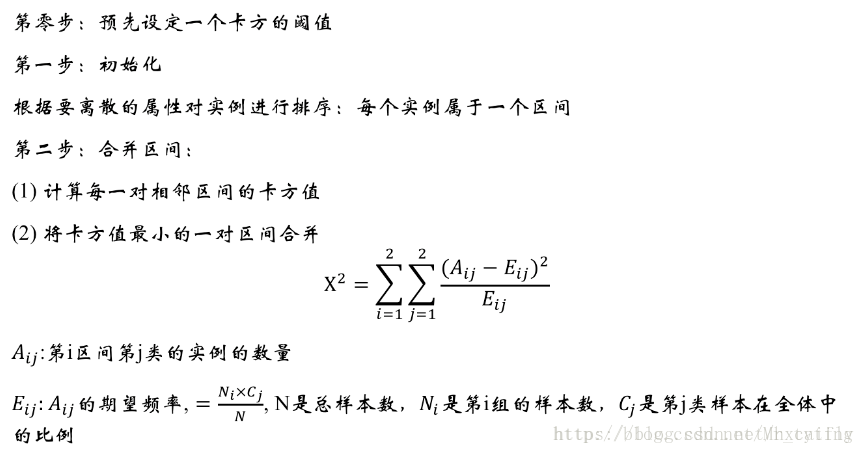

这里需要注意初始化时需要对实例进行排序，在排序的基础上进行合并。

卡方阈值的确定：
　　根据显著性水平和自由度得到卡方值
　　自由度比类别数量小1。例如：有3类,自由度为2，则90%置信度(10%显著性水平)下，卡方的值为4.6。

阈值的意义
　　类别和属性独立时,有90%的可能性,计算得到的卡方值会小于4.6。
　　大于阈值4.6的卡方值就说明属性和类不是相互独立的，不能合并。如果阈值选的大,区间合并就会进行很多次,离散后的区间数量少、区间大。


### 特征交互
- 交互特征的构造非常简单，使用起来却代价不菲。如果线性模型中包含有交互特征对，那它的训练时间和评分时间就会从 O(n) 增加到 O($n^2$)，其中 n 是单一特征的数量。

In [22]:
for col in ['grade', 'subGrade']: 
    temp_dict = train.groupby([col])['isDefault'].agg(['mean']).reset_index().rename(columns={'mean': col + '_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col + '_target_mean'].to_dict()

    train[col + '_target_mean'] = train[col].map(temp_dict)
    test_a[col + '_target_mean'] = test_a[col].map(temp_dict)

In [23]:
# 其他衍生变量 mean 和 std
for df in [train, test_a]:
    for item in ['n0','n1','n2','n2.1','n4','n5','n6','n7','n8','n9','n10','n11','n12','n13','n14']:
        df['grade_to_mean_' + item] = df['grade'] / df.groupby([item])['grade'].transform('mean')
        df['grade_to_std_' + item] = df['grade'] / df.groupby([item])['grade'].transform('std')

### 3.3.6 特征编码


#### labelEncode 直接放入树模型中


In [24]:
# label-encode:subGrade,postCode,title
# 高维类别特征需要进行转换
for col in tqdm(['employmentTitle', 'postCode', 'title','subGrade']):
    le = LabelEncoder()
    le.fit(list(train[col].astype(str).values) + list(test_a[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype(str).values))
    test_a[col] = le.transform(list(test_a[col].astype(str).values))
print('Label Encoding 完成')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.81s/it]

Label Encoding 完成



#### 逻辑回归等模型要单独增加的特征工程
- 对特征做归一化，去除相关性高的特征
- 归一化目的是让训练过程更好更快的收敛，避免特征大吃小的问题
- 去除相关性是增加模型的可解释性，加快预测过程。

```python
# 举例归一化过程
#伪代码
for fea in [要归一化的特征列表]：
    data[fea] = ((data[fea] - np.min(data[fea])) / (np.max(data[fea]) - np.min(data[fea])))
```

### 特征选择
- 特征选择技术可以精简掉无用的特征，以降低最终模型的复杂性，它的最终目的是得到一个简约模型，在不降低预测准确率或对预测准确率影响不大的情况下提高计算速度。特征选择不是为了减少训练时间（实际上，一些技术会增加总体训练时间），而是**为了减少模型评分时间**。

特征选择的方法：

- 1 Filter
  - 方差选择法
  - 相关系数法（pearson 相关系数）
  - 卡方检验
  - 互信息法
- 2 Wrapper （RFE）
  - 递归特征消除法
- 3 Embedded
  - 基于惩罚项的特征选择法
  - 基于树模型的特征选择


#### Filter
- 基于特征间的关系进行筛选

方差选择法
- 方差选择法中，先要计算各个特征的方差，然后根据设定的阈值，选择方差大于阈值的特征


```python
from sklearn.feature_selection import VarianceThreshold
#其中参数threshold为方差的阈值
VarianceThreshold(threshold=3).fit_transform(train,target_train)
```

In [25]:
from sklearn.feature_selection import VarianceThreshold
#其中参数threshold为方差的阈值
VarianceThreshold(threshold=3).fit_transform(train,taget_train)

NameError: name 'taget_train' is not defined

相关系数法
- Pearson 相关系数
  皮尔森相关系数是一种最简单的，可以帮助理解特征和响应变量之间关系的方法，该方法衡量的是变量之间的线性相关性。
  结果的取值区间为 [-1，1] ， -1 表示完全的负相关， +1表示完全的正相关，0 表示没有线性相关。


```python
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数

SelectKBest(k=5).fit_transform(train,target_train)
```

In [26]:
from sklearn.feature_selection import SelectKBest
from scipy.stats import pearsonr
#选择K个最好的特征，返回选择特征后的数据
#第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
#输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
#参数k为选择的特征个数

SelectKBest(k=5).fit_transform(train,target_train)

NameError: name 'target_train' is not defined

#### 卡方检验
- 经典的卡方检验是用于检验自变量对因变量的相关性。 假设自变量有N种取值，因变量有M种取值，考虑自变量等于i且因变量等于j的样本频数的观察值与期望的差距。 其统计量如下： $χ^2=∑(A−T)^2T$，其中A为实际值，T为理论值
- (注：卡方只能运用在正定矩阵上，否则会报错Input X must be non-negative)


```python
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#参数k为选择的特征个数

SelectKBest(chi2, k=5).fit_transform(train,target_train)
```

#### 互信息法
- 经典的互信息也是**评价自变量对因变量的相关性的**。 在feature_selection库的SelectKBest类结合最大信息系数法可以用于选择特征，相关代码如下：


```python
from sklearn.feature_selection import SelectKBest
from minepy import MINE
#由于MINE的设计不是函数式的，定义mic方法将其为函数式的，
#返回一个二元组，二元组的第2项设置成固定的P值0.5
def mic(x, y):
    m = MINE()
    m.compute_score(x, y)
    return (m.mic(), 0.5)
#参数k为选择的特征个数
SelectKBest(lambda X, Y: array(map(lambda x:mic(x, Y), X.T)).T, k=2).fit_transform(train,target_train)
```


#### Embedded
- 基于惩罚项的特征选择法 使用**带惩罚项**的基模型，除了筛选出特征外，同时也进行了降维。 在feature_selection库的SelectFromModel类结合逻辑回归模型可以用于选择特征，相关代码如下：



```python
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
#带L1惩罚项的逻辑回归作为基模型的特征选择

SelectFromModel(LogisticRegression(penalty="l1", C=0.1)).fit_transform(train,target_train)
```

- 基于树模型的特征选择 树模型中GBDT也可用来作为基模型进行特征选择。 在feature_selection库的SelectFromModel类结合GBDT模型可以用于选择特征，相关代码如下：



```python
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
#GBDT作为基模型的特征选择
SelectFromModel(GradientBoostingClassifier()).fit_transform(train,target_train)
```



本数据集中我们删除非入模特征后，并对缺失值填充，然后用计算协方差的方式看一下特征间相关性，然后进行模型训练

In [27]:
# train = pd.read_csv('./train.csv')
# test_a = pd.read_csv('./testA.csv')
# 删除不需要的数据
for data in [train, test_a]:
    data.drop(['issueDate', 'id'], axis = 1, inplace = True)
    # inplace = True 直接在原数据集上进行修改
# 处理缺失值：用缺失值上面的值代替缺失值
train = train.fillna(axis=0, method='ffill')
x_train = train.drop(['isDefault'], axis=1)
# 字符型数据类型编码
for data in [train, test_a]:
    data['grade'] = data['grade'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7})
# 类型数在2之上，不是高维稀疏的,且是分类特征
for data in [train, test_a]:
    data = pd.get_dummies(data, columns=['subGrade', 'homeOwnership', 'verificationStatus', 'purpose', 'regionCode'], drop_first=True)

In [28]:
# 计算协方差并且转换成dataframe形式
data_corr = x_train.corrwith(train.isDefault) # 自变量和因变量之间的相关性
result = pd.DataFrame(columns=['features', 'corr'])
result['features'] = data_corr.index
result['corr'] = data_corr.values


- pandas.DataFrame.corrwith用于计算DataFrame中行与行或者列与列之间的相关性。

    Parameters：
    

        other：DataFrame, Series. Object with which to compute correlations.
        
        axis： {0 or ‘index’, 1 or ‘columns’}, default 0. 0 or ‘index’ to compute column-wise, 1 or ‘columns’ for row-wise.
        
        method：{‘pearson’, ‘kendall’, ‘spearman’} or callable.
        
        axis=0或者axis=‘index’ 表示计算列与列的相关性，axis=1或者axis=‘columns’ 表示计算行与行的相关性。method是计算相关性的方法，这里采用pearson correlation coefficient（皮尔逊相关系数）



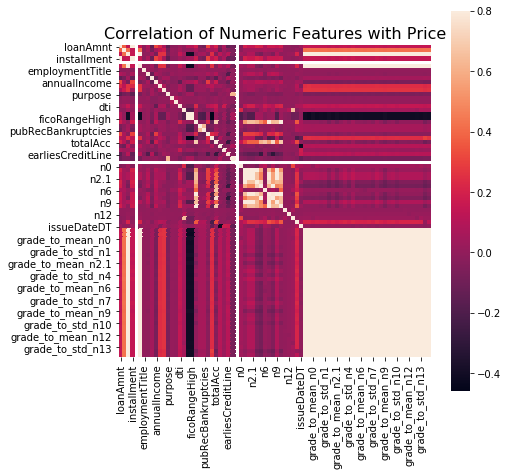

In [29]:
# 可视化描述
numerical_fea = list(train.select_dtypes(exclude=['object']).columns)
# 因为在上面得到numerical_fea时没有删除多余的数据特征，所以直接操作会出现keyerror
# 所以先在删除数据的新数据集上得到numerical_fea再进行其他操作。
data_numeric = train[numerical_fea]
correlation = data_numeric.corr()

f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation, square = True, vmax=0.8)


`seaborn.heatmap(data, vmin=None, vmax=None, cmap=None, center=None, robust=False,` 
总共有20个参数，肯定不是要我们记住的，而且这里的参数除了data以外，其他的都有默认值，所以首先会用基础的，知道怎么传递data是第一步。

    annot: 默认为False，为True的话，会在格子上显示数字
    vmax, vmin: 热力图颜色取值的最大值，最小值，默认会从data中推导


这里的data，如果接收的是干干净净的numpy二维数组的话，可以看到行标就是0,1,2，如果是DataFrame，就可以用列名来标记.

热力图的用途,是可视化数据，得到的data.corr()有很强的可视化效果。


In [30]:
# 分割数据特征和标签
features = [f for f in train.columns if f not in ['id','issueDate','isDefault'] and '_outliers' not in f]
x_train = train[features]
x_test = test_a[features]
y_train = train['isDefault']

In [31]:
x_train.shape

(800000, 77)

In [32]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    # 交叉验证模型
    folds = 5
    # 五折交叉验证
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed)

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        # 分割训练集和验证集
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.1,
                'seed': 2020,
                'nthread': 28,
                'n_jobs':24,
                'silent': True,
                'verbose': -1,
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_x , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [33]:
def lgb_model(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")
    return cat_train, cat_test

In [34]:
lgb_train, lgb_test = lgb_model(x_train, y_train, x_test)

************************************ 1 ************************************
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_threads is set with n_jobs=24, nthread=28 will be ignored. Current value: num_threads=24
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.74762	valid_1's auc: 0.735561
[400]	training's auc: 0.760266	valid_1's auc: 0.736308
[600]	training's auc: 0.771271	valid_1's auc: 0.736538
Early stopping, best iteration is:
[576]	training's auc: 0.770005	valid_1's auc: 0.736601
[0.7366013332903664]
************************************ 2 ************************************
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] num_threads is set with n_jobs=24, nthread=28 will be ignored. Current value: num_threads=24
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.748395	valid_1's auc: 0.731554
[400]	training's auc: 0.76097	valid_1's auc: 0.732675
[600]	training's a

## 3.4 总结

特征工程是机器学习，甚至是深度学习中最为重要的一部分，在实际应用中往往也是所花费时间最多的一步。各种算法书中对特征工程部分的讲解往往少得可怜，因为特征工程和具体的数据结合的太紧密，很难系统地覆盖所有场景。本章主要是通过一些常用的方法来做介绍，例如缺失值异常值的处理方法详细对任何数据集来说都是适用的。但对于分箱等操作本章给出了具体的几种思路，需要读者自己探索。在特征工程中比赛和具体的应用还是有所不同的，在实际的金融风控评分卡制作过程中，由于强调特征的可解释性，特征分箱尤其重要。学有余力同学可以自行多尝试，希望大家在本节学习中有所收获。

In [36]:
train.head()

,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,grade_to_mean_n10,grade_to_std_n10,grade_to_mean_n11,grade_to_std_n11,grade_to_mean_n12,grade_to_std_n12,grade_to_mean_n13,grade_to_std_n13,grade_to_mean_n14,grade_to_std_n14
0,35000.0,5,19.52,917.97,NaN,21,192025,2.0,2,110000.0,...,1.820574,3.980333,1.821304,3.863294,1.821980,3.863687,1.829339,3.856340,1.845480,3.899647
1,18000.0,5,18.49,461.90,NaN,16,104733,5.0,0,46000.0,...,1.458326,3.070714,1.457043,3.090635,1.457584,3.090949,1.463471,3.085072,1.476384,3.119718
2,12000.0,5,16.99,298.17,NaN,17,189509,8.0,0,74000.0,...,1.493590,3.014728,1.457043,3.090635,1.457584,3.090949,1.463471,3.085072,1.299807,3.019553
3,11000.0,3,7.26,340.96,NaN,3,249631,10.0,1,118000.0,...,0.363060,0.784788,0.364261,0.772659,0.364396,0.772737,0.365868,0.771268,0.391052,0.820342
4,3000.0,3,12.99,101.07,NaN,11,256267,10.0,1,29000.0,...,1.091589,2.314974,1.092782,2.317976,1.093188,2.318212,1.097603,2.313804,0.974855,2.264665
